In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import hashlib
import datetime
import time
import os

In [3]:
# open the api.txt file
with open('api.txt', 'r') as f:
    pub_api = f.read()
# run the api key
with open('priv_api.txt', 'r') as f:
    priv_api = f.read()
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


In [4]:
# def hash_params():
#     hash_md5 = hashlib.md5()
#     hash_md5.update(f'{timestamp}{priv_api}{pub_api}'.encode('utf-8'))
#     hashed_params = hash_md5.hexdigest()
#     return hashed_params
CHARACTER_URL = 'http://gateway.marvel.com/v1/public/characters'
def get_hash_and_ts_params():
    ts = str(time.time())
    combined = ''.join([ts, priv_api, pub_api])
    hash_value = hashlib.md5(combined.encode('ascii')).hexdigest()
    return {'ts': ts, 'hash': hash_value}


In [5]:
# params = {'ts': timestamp, 'apikey': pub_api, 'hash': hash_params()}
# response = requests.get("http://gateway.marvel.com/v1/public/comics", params=params)
# print(response.status_code)
def paged_requests(page_size=100):
      params = {'apikey': pub_api, 'limit': page_size}
      character_df = []
      for i in range(16):
          params.update({'limit': page_size})
          hash_params = get_hash_and_ts_params()
          params.update(hash_params)
          params.update({'offset': page_size * i}) # offset, how many records to skip
          resp = requests.get(CHARACTER_URL, params)
          # print(f'Requested page {i} of {page_size} records')
          resp.raise_for_status()  # stop if there are any errors!
        #   print(f'Full request URL: {resp.request.url}')
          j = resp.json()
          character_df.extend(j['data']['results'])
        #   print(f'First ten records: {character_df[:10]}')
      print('Done')
      # character_df = pd.DataFrame(character_df)
      return character_df

if __name__ == '__main__':
    character_df = paged_requests()
    character_df = pd.DataFrame(character_df)
    character_df.to_json('marvel.json', orient='records')
    character_df.to_csv('marvel.csv', index=False)

Done


In [23]:
with open('marvel.json') as f:
    data = json.load(f)

characters = []
for entry in data:
    character = {
        'name': entry['name'],
        # 'description': entry['description'],
        'comics_available': entry['comics']['available'],
        'series_available': entry['series']['available'],
        'stories_available': entry['stories']['available'],
        'events_available': entry['events']['available'] if 'events' in entry else None
    }

    character['comics_items'] = [item['name'] for item in entry['comics']['items']]
    character['series_items'] = [item['name'] for item in entry['series']['items']]
    character['stories_items'] = [item['name'] for item in entry['stories']['items']]
    
    if 'events' in entry:
        character['events_items'] = [item['name'] for item in entry['events']['items']]
    else:
        character['events_items'] = None

    characters.append(character)

df = pd.DataFrame(characters)

In [24]:
df

,name,comics_available,series_available,stories_available,events_available,comics_items,series_items,stories_items,events_items
0,3-D Man,12,3,21,1,"[Avengers: The Initiative (2007) #14, Avengers...","[Avengers: The Initiative (2007 - 2010), Deadp...","[Cover #19947, The 3-D Man!, Cover #19949, The...",[Secret Invasion]
1,A-Bomb (HAS),4,2,7,0,"[FREE COMIC BOOK DAY 2013 1 (2013) #1, Hulk (2...","[FREE COMIC BOOK DAY 2013 1 (2013), Hulk (2008...","[Hulk (2008) #55, Interior #92079, Hulk (2008)...",[]
2,A.I.M.,53,36,57,0,"[Ant-Man & the Wasp (2010) #3, Avengers (1998)...","[Ant-Man & the Wasp (2010 - 2011), Avengers (1...","[Avengers and Power Pack Assemble! (2006) #2, ...",[]
3,Aaron Stack,14,3,27,0,"[Dark Avengers (2012) #177, Dark Avengers (201...","[Dark Avengers (2012 - 2013), Hulk (2008 - 201...","[Universe X (2000) #10, Interior #25635, Unive...",[]
4,Abomination (Emil Blonsky),58,28,68,1,"[Abominations (1996) #1, Abominations (1996) #...","[Abominations (1996 - Present), Avengers (1998...","[4 of 4 - 4XLS, Irredeemable Ant-Man (2006) #1...",[Chaos War]
...,...,...,...,...,...,...,...,...,...
1558,Zeus,36,13,43,0,"[Avengers (1963) #50, Avengers (1963) #283, Av...","[Avengers (1963 - 1996), Avengers No Road Home...","[Whom the Gods Would Destroy, Battleground: O...",[]
1559,Zodiak,1,1,1,0,[Defenders (1972) #50],[Defenders (1972 - 1986)],[Story to Defenders #50],[]
1560,Zombie (Simon Garth),1,1,1,0,[Strange Tales (1998) #1],[Strange Tales (1998)],[],[]
1561,Zuras,3,3,3,0,"[Eternals (1976) #5, Eternals by Jack Kirby (H...","[Eternals (1976 - 1978), Eternals by Jack Kirb...","[ETERNALS (1976) #5, Hulk (2008) #49, Interior...",[]


Text(0.5, 1.0, 'Frequency of Original Avengers Characters in Comics')

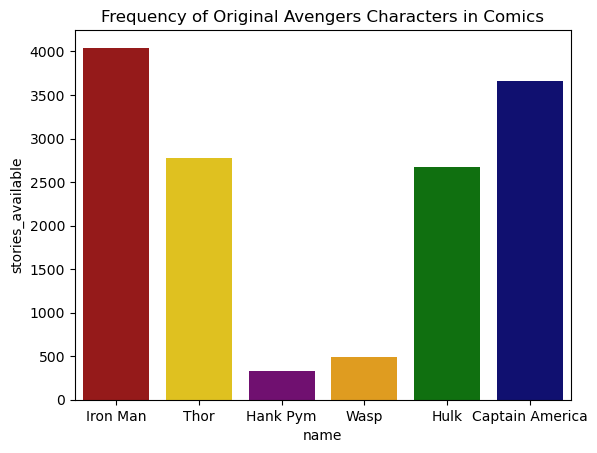

In [59]:
# make a plot showing the frequency of each original avenger character
avengers = [
    "Iron Man", "Thor", "Hank Pym", "Wasp", "Hulk", "Captain America"
]
avenger_colors = {
    "Iron Man": "#aa0505",
    "Thor": "gold",
    "Hank Pym": "purple",
    "Wasp": "orange",
    "Hulk": "green",
    "Captain America": "navy",
}

#plot the frequency of each original avenger character in comics
sns.barplot(data=df, x="name", y="stories_available", 
order=avengers, palette=avenger_colors.values()).set_title("Frequency of Original Avengers Characters in Comics")